# Concept Drift Detection With SyncStream



In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### SEA

In [2]:
data, meta = arff.loadarff("synthetic_data/abrupt_drift/sea_1_abrupt_drift_0_noise_balanced.arff")
# data, meta = arff.loadarff("synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_1.arff")
# data, meta = arff.loadarff("synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_5.arff")
# data, meta = arff.loadarff("synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_05.arff")
# data, meta = arff.loadarff("synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_10.arff")
# data, meta = arff.loadarff("synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_20.arff")

df = pd.DataFrame(data)

print(df.head())

le = LabelEncoder()
X = df[["attrib1", "attrib2", "attrib3"]]
y = le.fit_transform(df["class"].str.decode("utf-8"))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

    attrib1   attrib2   attrib3      class
0  7.308782  4.100808  2.077148  b'groupB'
1  5.833539  0.422983  7.616747  b'groupA'
2  1.397627  6.949480  8.052278  b'groupB'
3  2.750299  0.753878  6.105915  b'groupA'
4  2.049135  6.233638  1.847071  b'groupB'
(30000, 3)
(30000,)
(70000, 3)
(70000,)


### AGRAW

In [3]:
# data, meta = arff.loadarff("agraw1_1_abrupt_drift_0_noise_balanced.arff")
# # data, meta = arff.loadarff("agraw2_1_abrupt_drift_0_noise_balanced.arff")

# df = pd.DataFrame(data)

# # print(df.head())

# le = LabelEncoder()
# te = TargetEncoder(cols=["elevel", "car", "zipcode"], smoothing=0, return_df=True)

# X = df.drop(columns=["class"])
# y = le.fit_transform(df["class"].str.decode("utf-8"))

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

# X_train = te.fit_transform(X_train, y_train)
# X_test = te.transform(X_test)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

# X_train.head()

### Optimise hyperparameters:

In [4]:
# k_range = range(7, 21)

# k_scores = []

# for k in k_range:
#     model = KNeighborsClassifier(n_neighbors=k)
#     k_scores.append(cross_val_score(model, X_train.values, y_train, cv=10).mean()) 

# plt.plot(k_range, k_scores)
# plt.show()

### Train a generic model to evaluate:

In [5]:
model = KNeighborsClassifier(n_neighbors=13)
model.fit(X_train.values, y_train)

prediction = model.predict([[7.3, 4.1, 2.1]])
print(le.inverse_transform(prediction))

['groupB']


### Divide the test data into batches:

In [6]:
X_ref_batch = np.array_split(X_train, 3)[2]
y_ref_batch = np.array_split(y_train, 3)[2]

X_test_batches = np.array_split(X_test, 7)
y_test_batches = np.array_split(y_test, 7)

print(X_ref_batch.shape)
print(X_test_batches[0].shape)

(10000, 3)
(10000, 3)


### Compute model accuracy on each batch and verify drop:

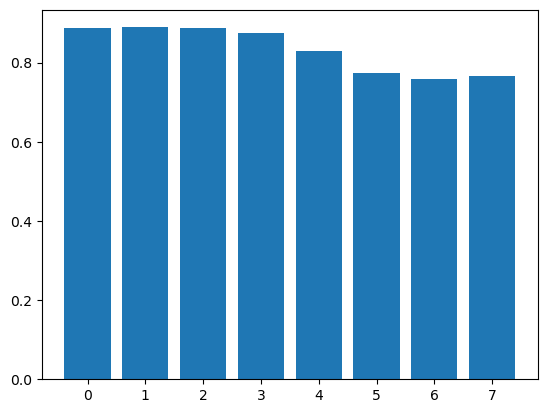

In [7]:
accs = [model.score(X_ref_batch.values, y_ref_batch)]

for batch in range(len(X_test_batches)):
    accs.append(model.score(X_test_batches[batch].values, y_test_batches[batch]))
    
plt.bar(range(0, len(X_test_batches) + 1), accs)
plt.show()

### Implement label-independent drift detectors:

### SyncStream-PCA

In [8]:
pca = PCA(n_components=1)

def detect_drift_pca(values, previous_eigenvector):
    pca.fit(values)
    angle = np.degrees(np.arccos(np.dot(pca.components_[0], previous_eigenvector)))
    detected = angle > 40
    print(pca.components_[0])
    print(angle)
    return detected, pca.components_[0]

In [9]:
train_collections = {}

for i in range(len(y_ref_batch)):
    label = le.inverse_transform([y_ref_batch[i]])[0]
    if not label in train_collections.keys():
        train_collections[label] = []
    train_collections[label].append(X_ref_batch.values[i])

current_eigenvectors = {}

for label in train_collections.keys():
    pca.fit(train_collections[label])
    current_eigenvectors[label] = pca.components_[0]
    print("\n")
    print("batch: 0")
    print("label:", label)
    print(pca.components_[0])
    
drifts = []

for batch in range(len(X_test_batches)):
    predictions = le.inverse_transform(model.predict(X_test_batches[batch].values))
    collections = {}
    for i in range(len(predictions)):
        prelabel = predictions[i]
        if not prelabel in collections.keys():
            collections[prelabel] = []
        collections[prelabel].append(X_test_batches[batch].values[i])
    
    for prelabel in collections.keys():
        print("\n")
        print("batch:", batch + 1)
        print("prelabel:", prelabel)
        detected_pca, new_eigenvector = detect_drift_pca(collections[prelabel], current_eigenvectors[prelabel])
        current_eigenvectors[prelabel] = new_eigenvector
        if (detected_pca):
            drifts.append(batch + 1)
            
print("\n")
print(drifts)



batch: 0
label: groupB
[ 0.68126352 -0.72847937  0.072096  ]


batch: 0
label: groupA
[ 0.02907893 -0.01180819  0.99950737]


batch: 1
prelabel: groupB
[-0.71278223  0.70114627 -0.01831427]
176.09934344174556


batch: 1
prelabel: groupA
[-0.0181083   0.01557732  0.99971468]
3.126366968735795


batch: 2
prelabel: groupB
[-0.71497627  0.69439879  0.08135884]
5.727684172088563


batch: 2
prelabel: groupA
[ 0.01239764 -0.01420433  0.99982225]
2.442874503381286


batch: 3
prelabel: groupA
[ 0.02025842 -0.01425409  0.99969316]
0.45046069074906586


batch: 3
prelabel: groupB
[-0.71405582  0.69827226 -0.0503999 ]
7.558143961836823


batch: 4
prelabel: groupA
[ 0.01229499 -0.01358588 -0.99983211]
177.54556727885677


batch: 4
prelabel: groupB
[-0.72891365  0.68333096 -0.04175751]
1.3049241211141251


batch: 5
prelabel: groupA
[-0.05874918  0.05641597  0.99667737]
176.37462270615262


batch: 5
prelabel: groupB
[ 0.70964726 -0.70236353  0.05555386]
178.2585070521864


batch: 6
prelabel: groupB


### SyncStream-Stat